# Selection llc + parcels data in a region

In [1]:
import os, shutil

import xarray as xr
import pandas as pd
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

from xmitgcm.llcreader import llcmodel as llc

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---

## define a region of interest


In [3]:
# select a region, here California
#region="california"
region="south_china_sea"

if region=="california":
    combine_faces=False
    isel = dict(face=10, i=slice(2500, 3500), j=slice(0, 1000))
else:
    combine_faces=True
    isel = dict(face=[4,5], i=slice(6500, 8000), j=slice(8000,9500))

#out_dir = os.path.join("/home/datawork-lops-osi/aponte/mit4320", "california")
out_dir = os.path.join(ut.diag_dir, region)

# index chosen for the parcel data
parcels_index = "time"

rechunk = False

# output archives
llc_zarr = os.path.join(out_dir, "llc.zarr")
parcels_name = "parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

# adjust dict
isel["i_g"] = isel["i"]
isel["j_g"] = isel["j"]

# create directory if not existing
os.makedirs(out_dir, exist_ok=True)

Start by plotting the bathymety

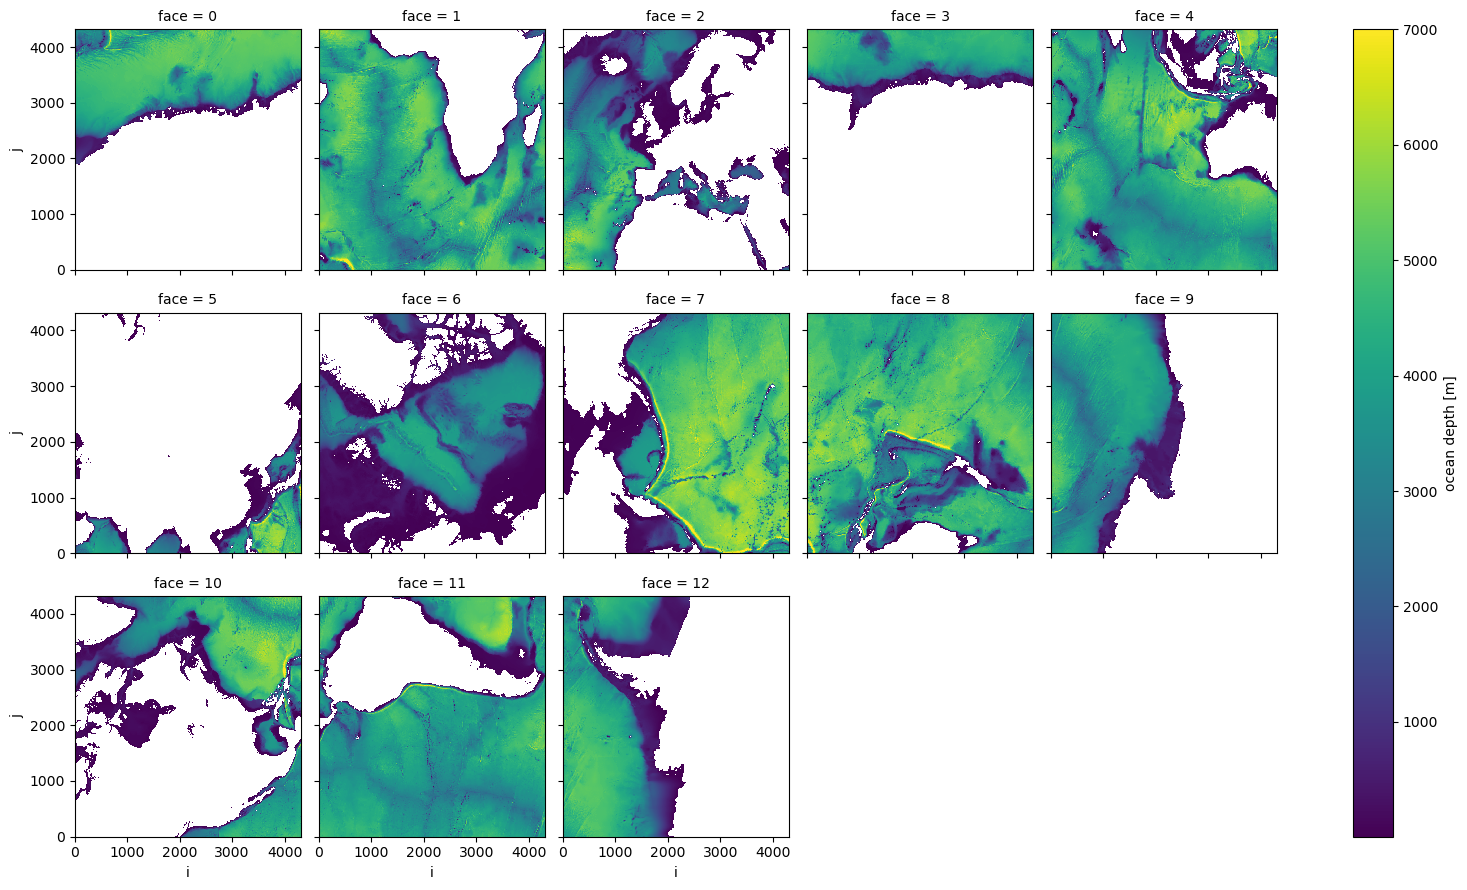

In [6]:
grd = ut.load_grd()

depth = grd.Depth.isel(i=slice(0,None,4), j=slice(0,None,4))
depth = depth.where(depth>0)

(depth
 .plot(col='face', col_wrap=5)
)

---
## load data llc, rechunk and store

if a region is too large, one my use the [rechunker library](https://rechunker.readthedocs.io/)

In [9]:
# 
V = ['SSU', 'SSV', 'Eta']
V += ['SST', 'SSS']
V += ["KPPhbl", "oceTAUX", "oceTAUY",]

ds = ut.load_data(V)
ds = ds.assign_coords(grd.coords)
ds

<xarray.Dataset>
Dimensions:  (time: 8585, face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320,
              k: 90, k_p1: 91, k_l: 90, k_u: 90)
Coordinates: (12/34)
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
    niter    (time) int64 dask.array<chunksize=(88,), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    ...       ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    KPPhbl   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    oceTAUX  (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    oceTAUY  (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [10]:
if combine_faces:
    #for v in 
    ds["SSV"].attrs['mate'] = "SSU"
    ds["SSU"].attrs['mate'] = "SSV"
    dsc = llc.faces_dataset_to_latlon(ds) #metric_vector_pairs=[]
    del isel["face"]
else:
    ds = ds.isel(**isel)
    dsc = None

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xmitgcm/llcreader/llcmodel.py:322: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(ifac * coords.dims[vname])
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xmitgcm/llcreader/llcmodel.py:324: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(jfac * coords.dims[vname])


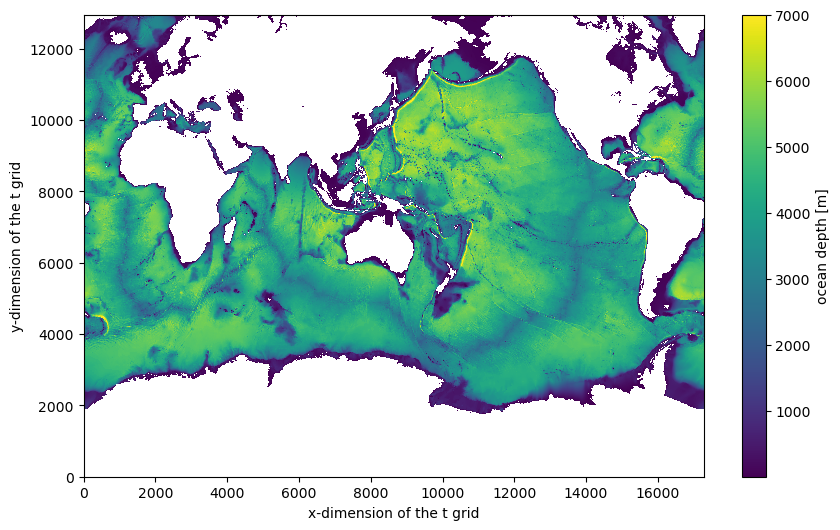

In [11]:
# search for bounds
if dsc is not None:
    depth = dsc.Depth.isel(i=slice(0,None,4), j=slice(0,None,4)).persist()
    depth = depth.where(depth>0)
    depth.plot(figsize=(10,6))

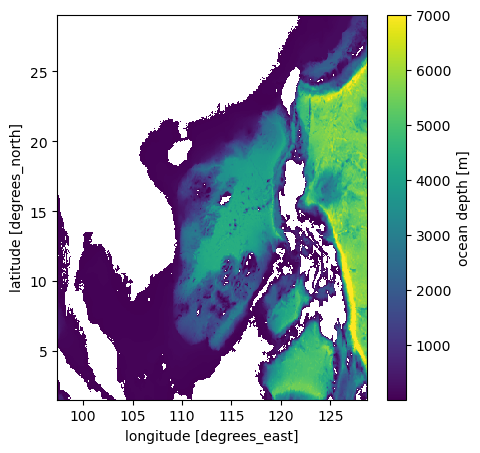

In [13]:
if dsc is not None:
    #6-24°N and 105-122°E
    (depth
     .sel(i=slice(6500, 8000), j=slice(8000,9500))
     .plot(x="XC", y="YC", figsize=(5,5))
    )

In [14]:
if combine_faces:
    ds = dsc.sel(**isel)#.persist()

In [15]:
# define target chunks
if rechunk:
    #chunks_new = dict(time=1024, i=128, j=128) # 512, 256, 256 may have been a better choice
    chunks_new = dict(time=1024, i=-1, j=128) # 512, 256, 256 may have been a better choice
    chunks_new["i_g"] = chunks_new["i"]
    chunks_new["j_g"] = chunks_new["j"]
    ds = ds.chunk(chunks_new)

In [18]:
# reset all coords chunks to -1
for v in ds.coords:
    ds[v] = ds[v].chunk(-1)

In [20]:
# reset all horizontal chunks to -1:
h_dims = ["i", "j", "i_g", "j_g"]
for v in ds:
    print(v)
    ds[v] = ds[v].chunk({d: -1 for d in ds[v].dims if d in h_dims})

Eta
SST
SSS
KPPhbl
SSU
SSV
oceTAUX
oceTAUY


In [74]:
#ds = ut._reset_chunk_encoding(ds)
#for v in ds.coords:
#    if "chunks" in ds[v].encoding:
#        del ds[v].encoding["chunks"]

In [22]:
#ds["dxC"].encoding

In [23]:
ds.to_zarr(llc_zarr, mode="w")

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 43.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### split into several zarrs for file sending

In [4]:
ds = xr.open_zarr(llc_zarr)

In [6]:
from numpy import array_split

In [17]:
time_split = array_split(ds.time.values, 4)

for i, split in enumerate(time_split):
    _ds = (
        ds
        .sel(time=slice(split[0], split[-1]))
        .drop_vars("face")
    )
    #print(_ds)
    zarr = llc_zarr.replace(".zarr", f"_{i}.zarr")
    _ds.to_zarr(zarr, mode="w")
    print(i, zarr)    

0 /home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/llc_0.zarr
1 /home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/llc_1.zarr
2 /home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/llc_2.zarr
3 /home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/llc_3.zarr


--- 
## load parcels data, subselect and store

In [8]:
# reload if necessary
ds = xr.open_zarr(llc_zarr)

In [ ]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
#run_name = 'global_extra_T365j_dt1j_dij50'
run_name = 'global_T365j_dt1j_dij50'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index].persist()

df.head()

Extract geographical extent from llc grid

In [12]:
llc_lon, llc_lat = ds.XC.compute(), ds.YC.compute()
extent = [float(llc_lon.min()), float(llc_lon.max()), 
          float(llc_lat.min()), float(llc_lat.max()),
         ]
extent

[97.42708587646484, 128.6770782470703, 1.5575294494628906, 29.029830932617188]

In [15]:
# check lon is between -180 180
print(df["lon"].min().compute(), df["lon"].max().compute())
# fix lon/lat
df["lon"] = (df["lon"]+180)%360-180
print(df["lon"].min().compute(), df["lon"].max().compute())

-237.69231124960288 253.41992169917634
-179.99999869060193 179.99999979947808


In [18]:
# extract relevant trajectory indices
_df = df[ (df.lon>extent[0])
        &(df.lon<extent[1])
        &(df.lat>extent[2])
        &(df.lat<extent[3])
       ]
#traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
traj = _df["trajectory"].unique().compute()
df_selected = df[df.trajectory.isin(traj)].persist()

df_selected = df_selected.repartition(partition_size="100MB").persist()

pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

In [26]:
pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/parcels_time


'/home/datawork-lops-osi/equinox/mit4320/diags/south_china_sea/parcels_time'

---

## make a quick plot for check

In [29]:
# llc
ds = xr.open_zarr(llc_zarr)
ds = ds.isel(time=0).compute()
t = pd.Timestamp(str(ds.time.values))

# drifters, load in memory (not that large)
df = dd.read_parquet(parcels_path).compute()
traj = df["trajectory"].unique()

Text(0.5, 1.0, '2011-11-23 08:00:00')

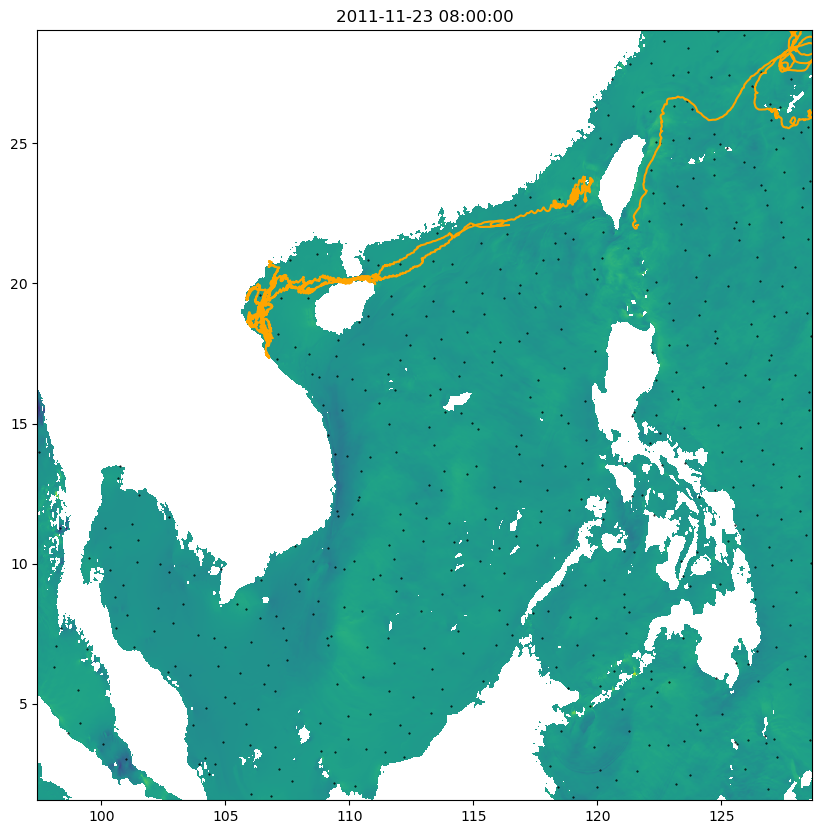

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

_df = df.loc[t]
ax.plot(_df.lon,_df.lat,".", color="k", markersize=1.)
#ax.plot(df.lon,df.lat,".", color="k", markersize=.1)

for i in [10,20,30]:
    _df = df.reset_index().set_index("trajectory").loc[traj[i]].set_index("time").sort_index()
    ax.plot(_df.lon, _df.lat, color="orange")

ax.pcolormesh(ds.XC, ds.YC, ds.SSV)

xlims = float(ds.XC.min()), float(ds.XC.max())
ylims = float(ds.YC.min()), float(ds.YC.max())
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_title(str(t))

---
## close cluster

In [10]:
cluster.close()